In [4]:
from rich.logging import RichHandler
import logging
from lightning_lite.utilities.seed import seed_everything
from shell_data.dataset.dataset import get_train_val_test_subsets
import torch
import os
from shell_data.utils.config import (
    ShELLDataSharingConfig,
    DatasetConfig,
    TaskModelConfig,
    TrainingConfig,
)
from shell_data.shell_agent.shell_agent_classification import ShELLClassificationAgent

import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"
torch.use_deterministic_algorithms(True)
seed_everything(0)


INFO:lightning_lite.utilities.seed:Global seed set to 0


0

In [5]:
def to_features(X):
    return X.view(X.size(0), -1)

def dist(X, X2, p=2):
    return torch.cdist(to_features(X), to_features(X2), p=p)

In [6]:
def knn_dist(X, refs, k=5, p=2):
    """
    For each point x in X, compute the mean of the `k` closest
    points to x in refs
    """
    d = dist(X, refs, p=p)
    closest_d, closest_idx = d.topk(k, dim=1, largest=False)
    return closest_d.mean(dim=1)

In [7]:
dataset_name = "mnist"
train_subsets, val_subsets, test_subsets = get_train_val_test_subsets(
    dataset_name)
size = 128
num_cls_per_task = 2

cfg = ShELLDataSharingConfig(
    n_agents=1,
    dataset=DatasetConfig(
        name=dataset_name,
        train_size=size,
        val_size=min(size, min([len(d) for d in val_subsets])),
        num_task_per_life=1,
        num_cls_per_task=num_cls_per_task,
    ),
    task_model=TaskModelConfig(
        name=dataset_name,
    ),
    training=TrainingConfig(
        n_epochs=100,
    )
)

In [8]:
model_name = "mnist_128_2.pt"
buffer_name = "mnist_buffer"
receiver = ShELLClassificationAgent(
        train_subsets, val_subsets, test_subsets, cfg,
        enable_validate_config=False,)
receiver.load_model(model_name)
receiver.load_buffer(buffer_name)
print("buffer len:", [len(b) for b in receiver.buffer.buffers])
print("past tasks:", receiver.buffer.past_tasks)

buffer len: [0, 0, 0, 0, 0, 128, 0, 128, 0, 0]
past tasks: [5, 7]


In [9]:
test = receiver.test(0)
val = receiver.val(0)
test, val

(0.9854166666666667, 0.9921875)

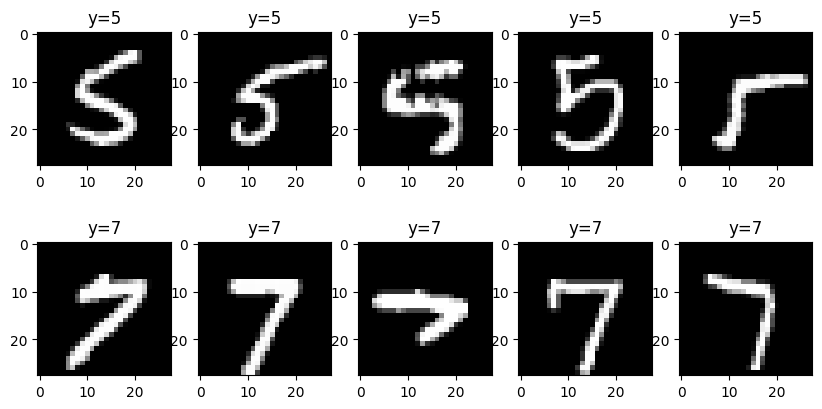

In [10]:
# sample a few images from the buffer and plot them
X, y = receiver.buffer.get_data(10)

# plot the images X and y
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
    axs[i//5, i%5].imshow(X[i].reshape(28, 28), cmap='gray')
    axs[i//5, i%5].set_title(f"y={y[i]}")

In [11]:
sender1 = ShELLClassificationAgent(
        train_subsets, val_subsets, test_subsets, cfg,
        enable_validate_config=False,)

sender2 = ShELLClassificationAgent(
        train_subsets, val_subsets, test_subsets, cfg,
        enable_validate_config=False,)

sender1.ll_dataset.perm = torch.tensor([5, 1])  # should route 5
sender2.ll_dataset.perm = torch.tensor([7, 2])  # should route 7

In [12]:
data = sender1.ll_dataset.get_train_dataset(0)
dataloader = torch.utils.data.DataLoader(
    # data, batch_size=len(data)//2,
    data, batch_size=len(data),
    shuffle=True,
)

sender_X, sender_y = next(iter(dataloader))

In [13]:
receiver_X, receiver_y = receiver.buffer.get_data(len(receiver.buffer))
receiver_y.shape

torch.Size([256])

In [14]:
receiver_X_cl5 = receiver_X[receiver_y == 5]
receiver_X_cl7 = receiver_X[receiver_y == 7]

# print(dist(receiver_X_cl5, receiver_X_cl5).mean())
# print(dist(receiver_X_cl7, receiver_X_cl7).mean())
# print(dist(receiver_X_cl5, receiver_X_cl7).mean())

k = 3
print("within cls 5", knn_dist(receiver_X_cl5, receiver_X_cl5, k=k).mean())
print("within cls 7", knn_dist(receiver_X_cl7, receiver_X_cl7, k=k).mean())
print("between 5 vs 7", knn_dist(receiver_X_cl5, receiver_X_cl7, k=k).mean())
print("within sender", knn_dist(sender_X, sender_X, k=k).mean())

# embeddings

with torch.no_grad():
    receiver_X_cl5_embed = receiver.model.net.embedding(receiver_X_cl5.to("cuda")).cpu()
    receiver_X_cl7_embed = receiver.model.net.embedding(receiver_X_cl7.to("cuda")).cpu()
    receiver_X_embed = receiver.model.net.embedding(receiver_X.to("cuda")).cpu()
    # print(dist(receiver_X_cl5_embed, receiver_X_cl5_embed).mean())
    # print(dist(receiver_X_cl7_embed, receiver_X_cl7_embed).mean())
    # print(dist(receiver_X_cl7_embed, receiver_X_cl5_embed).mean())

print("within cls 5 (embed):", knn_dist(receiver_X_cl5_embed, receiver_X_cl5_embed, k=k).mean())
print("within cls 7 (embed):", knn_dist(receiver_X_cl7_embed, receiver_X_cl7_embed, k=k).mean())
print("between 5 vs 7 (embed):", knn_dist(
    receiver_X_cl5_embed, receiver_X_cl7_embed, k=k).mean())

print("within entire dataset (embed):", knn_dist(receiver_X_embed, receiver_X_embed, k=k).mean())

within cls 5 tensor(4.3047)
within cls 7 tensor(3.6677)
between 5 vs 7 tensor(8.8258)
within sender tensor(3.1503)
within cls 5 (embed): tensor(6.1058)
within cls 7 (embed): tensor(5.6066)
between 5 vs 7 (embed): tensor(15.3188)
within entire dataset (embed): tensor(5.8419)


In [15]:

pca = PCA(n_components=2)
pca.fit(to_features(receiver_X_embed))
receiver_X_embed_2d = pca.transform(to_features(receiver_X_embed))

# reduce the raw (no embedding) data to 2D
pca = PCA(n_components=2)
pca.fit(to_features(receiver_X))
receiver_X_2d = pca.transform(to_features(receiver_X))


In [16]:
# concat receiver and sender data
joint_data = torch.cat([receiver_X, sender_X])
pca=PCA(n_components=2)
pca.fit(to_features(joint_data))
joint_data_2d = pca.transform(to_features(joint_data))

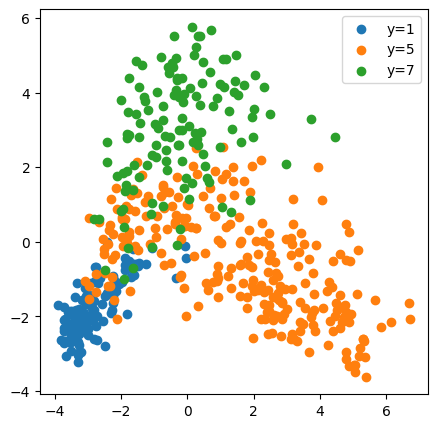

In [17]:
joint_y = torch.cat([receiver_y, sender_y])
# plot the data
fig, ax = plt.subplots(figsize=(5, 5))
for i in range(10):
    if len(joint_data[joint_y == i]) == 0:
        continue
    ax.scatter(joint_data_2d[joint_y == i, 0],
               joint_data_2d[joint_y == i, 1],
               label=f"y={i}")
ax.legend();

In [27]:
import umap
reducer = umap.UMAP()
# transform = reducer.fit(to_features(receiver_X))
reducer.fit(to_features(joint_data))

UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

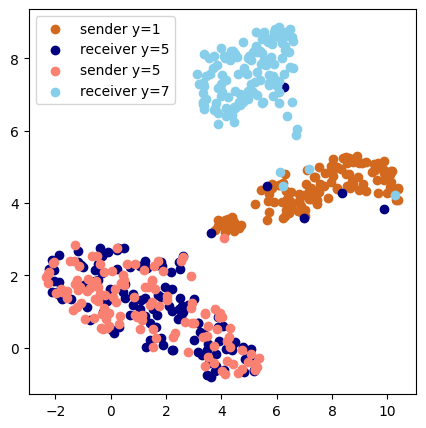

In [30]:
# plotting umap on receiver and sender data
fig, ax = plt.subplots(figsize=(5, 5))
red_colors = ["red", "darkred", "salmon", "chocolate"]
blue_colors = ["blue", "skyblue", "navy"]
for i in range(10):
    # plot receiver with bluish color and sender with reddish color
    if len(receiver_y[receiver_y == i]) > 0:
        ax.scatter(reducer.transform(to_features(receiver_X[receiver_y == i]))[:, 0],
                   reducer.transform(to_features(receiver_X[receiver_y == i]))[:, 1],
                   label=f"receiver y={i}", color=blue_colors.pop())
    if len(sender_y[sender_y == i]) > 0:
        ax.scatter(reducer.transform(to_features(sender_X[sender_y == i]))[:, 0],
                   reducer.transform(to_features(sender_X[sender_y == i]))[:, 1],
                   label=f"sender y={i}", color=red_colors.pop())
ax.legend();

In [32]:
# import sklearn.neighbors
# reducer = umap.UMAP()
# outlier_scores = sklearn.neighbors.LocalOutlierFactor(contamination='auto').fit_predict(reducer.fit_transform(to_features(joint_data)))

In [35]:
import sklearn.neighbors
# outlier_scores[outlier_scores == -1]
clf = sklearn.neighbors.LocalOutlierFactor(contamination='auto', novelty=True,)
# fit on receiver and predict on sender
clf.fit(reducer.transform(to_features(receiver_X)))
outlier_scores = clf.predict(reducer.transform(to_features(sender_X)))

In [39]:
sender_y[outlier_scores == -1]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
# plot the images 2D projectionf of receiver_X_embed_2d
# with color as the class and legend
fig, ax = plt.subplots(figsize=(5, 5))
for i in range(10):
    if len(receiver_X_2d[receiver_y == i]) == 0:
        continue
    ax.scatter(receiver_X_embed_2d[receiver_y == i, 0],
               receiver_X_embed_2d[receiver_y == i, 1],
               label=f"y={i}")
ax.legend();

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
for i in range(10):
    if len(receiver_X_2d[receiver_y == i]) == 0:
        continue
    ax.scatter(receiver_X_2d[receiver_y == i, 0],
               receiver_X_2d[receiver_y == i, 1],
               label=f"y={i}")
ax.legend();

In [ ]:
new_ds = knn_dist(receiver_X_embed, receiver_X_embed, k=k)
# barplot of the distribution of distances
plt.hist(new_ds);

In [ ]:
with torch.no_grad():
    sender_X_embed = receiver.model.net.embedding(sender_X.to("cuda")).cpu()

In [ ]:
sender_X_cls_5 = sender_X[sender_y == 5]
sender_X_cls_1 = sender_X[sender_y == 1]
sender_X_embed_cls_5 = sender_X_embed[sender_y == 5]
sender_X_embed_cls_1 = sender_X_embed[sender_y == 1]

In [ ]:
# NOTE: L2 distance might be problematic for computing "similarity" as 
# the intensity of the pixels are not normalized across classes.

In [ ]:
# NOTE: the distance between sender and receiver quite different between refs contains the target
# in one scenario
 
# IN-distribution
print("cls 5 between sender and receiver 5", knn_dist(sender_X_cls_5, receiver_X_cl5, k=k).mean())
print("cls 5 between sender and receiver 7", knn_dist(sender_X_cls_5, receiver_X_cl7, k=k).mean())
print("cls 5 between sender and receiver", knn_dist(sender_X_cls_5, receiver_X, k=k).mean())
print("cls 5 within sender", knn_dist(sender_X_cls_5, sender_X_cls_5, k=k).mean())
print("cls 5 within receiver", knn_dist(receiver_X_cl5, receiver_X_cl5, k=k).mean())

In [ ]:
# OUT-distribution
print("cls 1 between sender and receiver 7", knn_dist(sender_X_cls_1, receiver_X_cl7, k=k).mean())
print("cls 1 between sender and receiver 5", knn_dist(sender_X_cls_1, receiver_X_cl5, k=k).mean())
print("cls 1 between sender and receiver", knn_dist(sender_X_cls_1, receiver_X, k=k).mean())
print("cls 1 within sender", knn_dist(sender_X_cls_1, sender_X_cls_1, k=k).mean())

In [ ]:
# IN-distribution
print("EMBED version")
print("cls 5 between sender and receiver 5", knn_dist(sender_X_embed_cls_5, receiver_X_cl5_embed, k=k).mean())
print("cls 5 between sender and receiver 7", knn_dist(sender_X_embed_cls_5, receiver_X_cl7_embed, k=k).mean())
print("cls 5 between sender and receiver dataset", knn_dist(sender_X_embed_cls_5, receiver_X_embed, k=k).mean())
print("cls 5 within sender", knn_dist(sender_X_embed_cls_5, sender_X_embed_cls_5, k=k).mean())
print("cls 5 within receiver", knn_dist(receiver_X_cl5_embed, receiver_X_cl5_embed, k=k).mean())

In [ ]:
# OUT-distribution
print("EMBED version")
print("cls 1 between sender and receiver 7", knn_dist(sender_X_embed_cls_1, receiver_X_cl7_embed, k=k).mean())
print("cls 1 between sender and receiver 5", knn_dist(sender_X_embed_cls_1, receiver_X_cl5_embed, k=k).mean())
print("cls 1 between sender and receiver dataset", knn_dist(sender_X_embed_cls_1, receiver_X_embed, k=k).mean())
print("cls 1 within sender", knn_dist(sender_X_embed_cls_1, sender_X_embed_cls_1, k=k).mean())

In [ ]:
# plot new_ds on x axis where y is the label
plt.plot(new_ds.detach().cpu(), sender_y, "o")

In [ ]:
print(new_ds[sender_y== 1].mean(), new_ds[sender_y==5].mean())

In [ ]:
# TODO: new data doesn't follow this pattern. WTF???